# Implicit Richards’ Equation Solver using Picard iterative method (mixed form of RE)
**Governing equation (mixed‑form):**
$$
\frac{\partial \theta}{\partial t}
\;-\;\frac{\partial}{\partial z}\Bigl[K(\psi)\,\frac{\partial \psi}{\partial z}\Bigr]
\;-\;\frac{\partial K(\psi)}{\partial z}
\;=\;0
$$

- **ψ** = pressure head [cm]  
- **θ(ψ)** = volumetric water content [–]  
- **K(ψ)** = unsaturated hydraulic conductivity [cm/s]  

**Soil model:** van Genuchten–Mualem, parameters below.  
**Domain:** 180 cm depth (Δz = 2.0 cm)  
**Time:** up to 60 days, test Δt = 1 day  
**BCs:** daily rainfall time-series top BC, Free drainage bottom BC  
**IC:** ψ = –10000 cm (very dry initial condition)

# INPUT SECTION

In [7]:
# ——— 1. IMPORT PACKAGES ———

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ——— 2. RAINFALL–EVAPORATION TIME SERIES ———

# Rainfall (+) and evaporation (–) in cm/day over 60 days
values = [
 0.   ,  1.   ,  0.6  ,  0.8  ,  0.5  ,  0.1  ,  0.3  ,  0.6  ,
 0.7  ,  0.4  , -0.1  , -0.05 , -0.1  , -0.15 , -0.05 , -0.14 ,
-0.05 ,  0.   , -0.05 , -0.07 , -0.05 , -0.04 , -0.01 , -0.03 ,
-0.005, -0.03 , -0.04 , -0.02 , -0.01 , -0.005,  0.   ,  0.   ,
 0.   ,  0.   ,  0.8  ,  1.5  ,  0.5  ,  0.7  , -0.18 , -0.16 ,
-0.05 , -0.05 , -0.1  , -0.04 , -0.02 , -0.005, -0.01 , -0.005,
-0.005, -0.05 , -0.1  ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
 0.   ,  0.8  ,  1.4  ,  1.2
]

rain_evap = np.array(values)         # cm/day
qT = -rain_evap                      # top flux boundary (positive downward)
t = np.arange(len(qT))               # day indices [0, 1, ..., 59]
dt = 1                               # time step [days]
nt = len(t)                          # number of time steps

# ——— 3. SOIL PARAMETERS: GLENDALE CLAY LOAM ———

def setpars():
    """
    Return a dictionary of van Genuchten–Mualem parameters for
    Glendale clay loam. Units: cm, day.
    """
    pars = {}
    pars['thetaR'] = 0.1060      # residual water content [–]
    pars['thetaS'] = 0.4686      # saturated water content [–]
    pars['alpha']  = 0.0104      # inverse air-entry suction [1/cm]
    pars['n']      = 1.3954      # VG shape parameter
    pars['m']      = 1 - 1/pars['n']  # m = 1 - 1/n
    pars['Ks']     = 13.1        # saturated conductivity [cm/day]
    pars['Ss']     = 1e-6        # specific storage [1/cm]
    return pars

pars = setpars()

# ——— 4. GRID & INITIAL CONDITIONS ———

dz = 2                       # spatial resolution [cm]
zN = 180                     # total depth [cm]
z = np.arange(dz/2, zN, dz)  # cell centres [cm]
n = len(z)                   # number of vertical nodes

psi = np.zeros((nt, n))     # solution array [nt × n]

# Initial condition: very dry profile (e.g., wilting point or beyond)
psi[0, :] = -10000          # initial pressure head [cm]


# MODEL SET UP

In [8]:
# ——— 5. DEPENDENT VARIABLES: C(ψ), K(ψ), θ(ψ) ———

def Cfun(psi, pars):
    """
    Specific moisture capacity C(ψ) = dθ/dψ.
    Returns Ss when ψ ≥ 0.
    """
    α, n, m = pars['alpha'], pars['n'], pars['m']
    θs, θr  = pars['thetaS'], pars['thetaR']
    Ss      = pars['Ss']

    x3 = 1 + (α * np.abs(psi))**n
    x2 = x3**(m + 1)
    x1 = α * n * m * (α * np.abs(psi))**(n - 1) / x2

    return np.where(psi >= 0, Ss, (θs - θr) * x1)

def Kfun(psi, pars):
    """
    Hydraulic conductivity K(ψ) [cm/day].
    Returns Ks when ψ ≥ 0.
    """
    α, n, m, Ks = pars['alpha'], pars['n'], pars['m'], pars['Ks']

    x6 = 1 + (α * np.abs(psi))**n
    x5 = x6**(m * 0.5)
    x4 = (α * np.abs(psi))**(n - 1) * x6**(-m)
    x3 = 1 - x4
    x2 = x3**2
    x1 = x2 / x5

    return np.where(psi >= 0, Ks, Ks * x1)

def thetafun(psi, pars):
    """
    Volumetric water content θ(ψ) [–].
    Saturated when ψ ≥ 0.
    """
    α, n, m = pars['alpha'], pars['n'], pars['m']
    θs, θr  = pars['thetaS'], pars['thetaR']

    x3 = 1 + (α * np.abs(psi))**n
    x2 = x3**m
    x1 = (θs - θr) / x2

    return np.where(psi >= 0, θs, θr + x1)

# ——— 6. LINEAR SOLVER ———

def solverfun(R, C, Kmid, dt, dz, n):
    """
    Solve linear system A·Δψ = R using tridiagonal matrix.
    Mixed-form discretisation with Neumann BCs at both ends.
    """
    a = -Kmid[:-1] / dz
    b = (Kmid[:-1] + Kmid[1:]) / dz + C * dz / dt
    c = -Kmid[1:] / dz

    # Modify for boundary nodes
    b[0]  = Kmid[1]   / dz + C[0]   * dz / dt
    b[-1] = Kmid[-2]  / dz + C[-1]  * dz / dt

    A = np.diag(a[1:], -1) + np.diag(b, 0) + np.diag(c[:-1], 1)
    dell = np.linalg.solve(A, R)
    return dell

# ——— 7. RESIDUAL FUNCTION ———

def Rfun(psiiter, psiin, qT, KB, C, Kmid, dtheta, dt, dz, n):
    """
    Residual for Picard iteration (mixed form with flux BCs).
    qT is the rainfall/evaporation flux at the top [cm/day].
    KB is the K value at the bottom.
    """
    zero = np.array([0])
    psigrid = np.hstack((zero, psiiter, zero))  # padded for BCs

    x1 = -dtheta / dt * dz
    x2 = (Kmid[1:] - Kmid[:-1])
    x3 = Kmid[1:] * (psigrid[2:]   - psigrid[1:-1]) / dz
    x4 = -Kmid[:-1] * (psigrid[1:-1] - psigrid[:-2]) / dz

    # Apply boundary fluxes
    x2[0]  = Kmid[1]
    x4[0]  = -KB              # Free drainage bottom
    x2[-1] = -Kmid[-2]
    x3[-1] = -qT              # Imposed flux at top

    return x1 + x2 + x3 + x4

# ——— 8. PICARD ITERATION ———

def iterfun(psiin, pars, qT, dt, dz, n):
    """
    Picard iteration to solve ψ at next time step (mixed form).
    Converges when residual is below a given tolerance.
    """
    tolerance = 1e-10
    maxcount = 10000
    zero = np.array([0])

    psiiter = psiin.copy()
    psiout  = np.zeros_like(psiin)

    count = 0
    while count <= maxcount:
        C      = Cfun(psiiter, pars)
        Kfull  = Kfun(np.hstack((zero, psiiter, zero)), pars)
        Kmid   = 0.5 * (Kfull[1:] + Kfull[:-1])
        dtheta = thetafun(psiiter, pars) - thetafun(psiin, pars)
        R      = Rfun(psiiter, psiin, qT, Kfull[1], C, Kmid, dtheta, dt, dz, n)

        dell = solverfun(R, C, Kmid, dt, dz, n)
        psiout = psiiter + dell
        psiiter = psiout.copy()

        if np.max(np.abs(R)) < tolerance:
            break

        count += 1

    return psiout

# ——— 9. MASS BALANCE EVALUATION ———

def massbal(psi, qT, pars, n, dt, dz):
    """
    Mass balance check: storage change vs net flux.
    Top: prescribed flux qT. Bottom: free drainage (K(ψ₁)).
    """
    theta = thetafun(psi.reshape(-1), pars).reshape(psi.shape)
    S = np.sum(theta * dz, axis=1)
    S0, SN = S[0], S[-1]

    Kin = Kfun(psi[:, 0], pars)
    QIN = -Kin
    QIN[0] = 0
    QINsum = np.sum(QIN) * dt

    QOUT = qT.copy()
    QOUT[0] = 0
    QOUTsum = np.sum(QOUT) * dt

    dS  = SN - S0
    dQ  = QINsum - QOUTsum
    err = dS / dQ

    return QIN, QOUT, S, err

# ——— 10. TIME LOOP ———

def ModelRun(dt, dz, n, nt, psi, qT, pars):
    """
    Full time loop for simulation.
    For each day, use rainfall/evaporation value from qT.
    """
    for j in range(1, nt):
        psi[j, :] = iterfun(psi[j-1, :], pars, qT[j], dt, dz, n)

    QIN, QOUT, S, err = massbal(psi, qT, pars, n, dt, dz)
    return psi, QIN, QOUT, S, err

# SIMULATION RUN

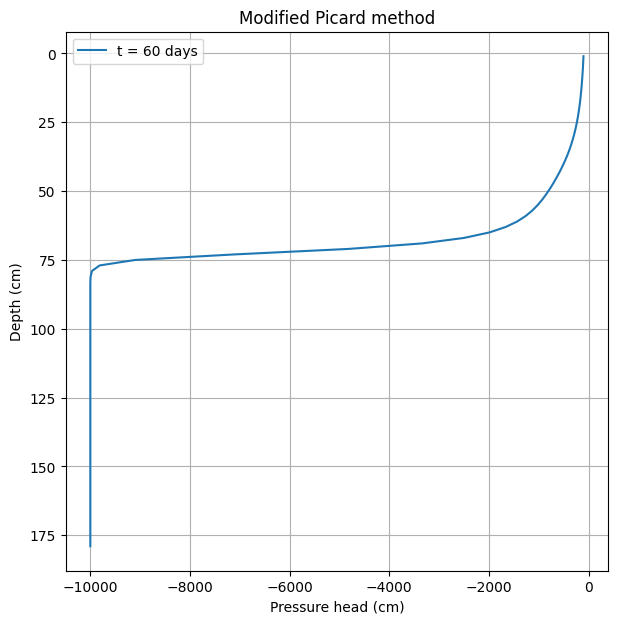

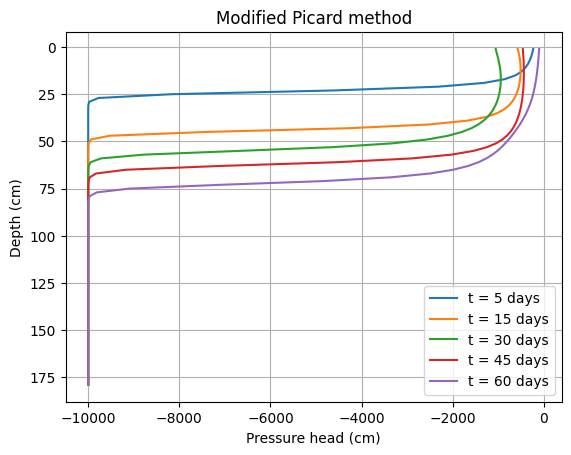

In [10]:
# ——— 11. RUN SIMULATION AND PLOT RESULTS ———

psi, QIN, QOUT, S, err = ModelRun(dt, dz, n, nt, psi, qT, pars)

# Plot final pressure head profile at t = 60 days
plt.figure(figsize=(7, 7))
z_depth = np.flip(z)
plt.plot(psi[59], z_depth, label='t = 60 days')
plt.xlabel('Pressure head (cm)')
plt.ylabel('Depth (cm)')
plt.gca().invert_yaxis()
plt.title('Modified Picard method')
plt.legend()
plt.grid(True)
plt.show()

# Plot pressure head profiles at selected times
time_steps = [4, 14, 29, 44, 59]
for t in time_steps:
    plt.plot(psi[t], z_depth, label=f't = {t+1} days')
plt.xlabel('Pressure head (cm)')
plt.ylabel('Depth (cm)')
plt.gca().invert_yaxis()
plt.title('Modified Picard method')
plt.legend()
plt.grid(True)
plt.show()